# Filling gaps - merged dataset - 2 sequences input
---
The notebook contains the code used in the process of preparing datasets and training neural network models with differing architecture, in order to analyse their capabilities in filling gaps present in aminoacid sequences. In this experiment, two sequences were an input for models.

---
Import necessary libraries.

In [81]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from keras.layers import (Bidirectional, Dense, Flatten, GRU, LSTM)
from keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils.vis_utils import plot_model

---
Function to put gaps in sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [82]:
def gap_sequence(df, gaps):
    gapped1 = []
    full2 = []
    full1 = []

    for _, row in df.iterrows():
        seq1, seq2 = row[0], row[1]
        full1.append(seq1)
        full2.append(seq2)

        inds = [i for i in range(len(seq1))]
        sam = random.sample(inds, gaps)

        for ind in sam:
            seq1 = seq1[:ind] + "_" + seq1[ind+1:]

        gapped1.append(seq1)

    new_df = pd.DataFrame({'gapped1': gapped1, 'full2': full2, 'full1': full1})
    return new_df
# def gap_sequences(column, gaps, repeat=1):
#   inds = []
#   seqs = []
#   gapped = []

#   for i in range(repeat):
#     for seq in column:
#       seqs.append(seq)
#       inds = [i for i, _ in enumerate(seq)]

#       samp = random.sample(inds, gaps)

#       for index in samp:
#         seq = seq[:index] + "_" + seq[index + 1:]

#       gapped.append(seq)

#   return seqs, gapped

---
Function to perform one-hot encoding on sequences (detailed description in the [Data_preparation](https://github.com/HPorada/aMLoid/blob/main/Data_preparation.ipynb) notebook).

In [83]:
char_to_int = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
               'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
               'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
               'Y': 19, '_': 20}

def one_hot_encoding(seqs, length=1):
  n_rows = len(seqs)
  max_seq_len = max(len(seqs[i]) for i in range(n_rows))
  max_len = max(max_seq_len, length)
  n_classes = len(char_to_int)

  encoded = np.zeros((n_rows, max_len, n_classes))

  for i in range(n_rows):
      seq = seqs[i]
      for j, letter in enumerate(seq):
        encoded[i, j, char_to_int[letter.upper()]] = 1

  return encoded

---
Functions returning different neural network structures analysed in the project (detailed description in chapter 5). They accept dimensions of input datasets as arguments.

In [84]:
def dense_2_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=sequence_length, activation='relu', input_shape=(sequence_length, num_amino_acids,)))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=num_amino_acids, activation='softmax'))
    return model

def LSTM_1_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def bidirectional_LSTM_model(sequence_length, num_amino_acids):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=sequence_length, input_shape=(sequence_length, num_amino_acids), return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

def GRU_3_model(sequence_length, num_amino_acids):
    model = keras.Sequential()
    model.add(GRU(128, input_shape=(sequence_length, num_amino_acids), return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(Dense(num_amino_acids, activation='softmax'))
    return model

---
Function returning a list of all models. Written to optimise preparation for performing training processes.

In [85]:
def get_all_models():
  models = [
    dense_2_model(sequence_length, num_amino_acids),
    LSTM_1_model(sequence_length, num_amino_acids),
    bidirectional_LSTM_model(sequence_length, num_amino_acids),
    GRU_3_model(sequence_length, num_amino_acids)
  ]
  return models

---
Function to train multiple models and return list of training results. Arguments given to the function must contain list of models to train, train and test datasets, number of epochs and a batch size. Other training parameters can be set too, but in the performed project they were not changed, so default values are used.

In [86]:
def train_models(models, X_train, y_train, X_test, y_test, epochs, batch_size, verbose=1, loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy']):
  results = []

  # Iterate through the given list of models
  for model in models:
    # Train each model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=[X_test, y_test])
    # Append history of training to the list of results
    results.append(history)

  # Return the list of results
  return results

---
Function displaing and saving plots of loss function, accuracy and top-5 categorical accuracy in the training process of all models.

It accepts a list of results of training, list of model names, colors and a title with which plots will be saved to PNG files.

In [87]:
def show_plots(results, model_names, colors, title):
  # Plot 1: Training and Validation Loss
  fig1, ax1 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training loss vs. epochs
      ax1.plot(hist.history['loss'], label=f"{model_names[i]}", color=color)
      # plot validation loss vs. epochs
      ax1.plot(hist.history['val_loss'], linestyle='dashed', color=color)

  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()
  ax1.set_xlim([0, epochs-1])

  # Plot 2: Training and Validation Accuracy
  fig2, ax2 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training accuracy vs. epochs
      ax2.plot(hist.history['accuracy'], label=f"{model_names[i]}", color=color)
      # plot validation accuracy vs. epochs
      ax2.plot(hist.history['val_accuracy'], linestyle='dashed', color=color)

  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy [-]")
  ax2.legend()
  ax2.set_xlim([0, epochs-1])
  ax2.set_ylim([0, 1])

  # Plot 3: Training and Validation Top-K Categorical Accuracy
  fig3, ax3 = plt.subplots(figsize=(10, 5))
  for i, hist in enumerate(results):
      color = colors[i]
      # plot training top-k accuracy vs. epochs
      ax3.plot(hist.history['top_k_categorical_accuracy'], label=f"{model_names[i]}", color=color)
      # plot validation top-k accuracy vs. epochs
      ax3.plot(hist.history['val_top_k_categorical_accuracy'], linestyle='dashed', color=color)

  ax3.set_xlabel("Epoch")
  ax3.set_ylabel("Top-K Categorical Accuracy [-]")
  ax3.legend()
  ax3.set_xlim([0, epochs-1])
  ax3.set_ylim([0, 1])

  # Save the figures
  fig1.savefig(f"{title}_loss.png")
  fig2.savefig(f"{title}_accuracy.png")
  fig3.savefig(f"{title}_top_k_accuracy.png")

  # Show the figures
  plt.show()

---
Open the file with merged dataset and split into train and test data in proportion 4:1.

In [88]:
data = pd.read_csv("merged_data.csv")

seq_or = data["interactor"]
seq_ee = data["interactee"]

data = pd.DataFrame(list(zip(seq_or, seq_ee)))

data_train, data_test = train_test_split(data, test_size=0.2, random_state=73)

print(f"Length of train dataset: {len(data_train)}")
print(f"Length of test dataset: {len(data_test)}")

Length of train dataset: 480
Length of test dataset: 120


---
Create datasets with:
* 1 gap
* 3 gaps
* 5 gaps

And concatenate gapped sequence of interactor (gapped1) with full sequence of interactee (full2).

In [89]:
new_train_1 = gap_sequence(data_train, 1)
new_test_1 = gap_sequence(data_test, 1)

new_train_1['gap1_full2'] = ''
new_test_1['gap1_full2'] = ''

for index, row in new_train_1.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_train_1.at[index, 'gap1_full2'] = con_value

for index, row in new_test_1.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_test_1.at[index, 'gap1_full2'] = con_value


new_train_3 = gap_sequence(data_train, 3)
new_test_3 = gap_sequence(data_test, 3)

new_train_3['gap1_full2'] = ''
new_test_3['gap1_full2'] = ''

for index, row in new_train_3.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_train_3.at[index, 'gap1_full2'] = con_value

for index, row in new_test_3.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_test_3.at[index, 'gap1_full2'] = con_value


new_train_5 = gap_sequence(data_train, 5)
new_test_5 = gap_sequence(data_test, 5)

new_train_5['gap1_full2'] = ''
new_test_5['gap1_full2'] = ''

for index, row in new_train_5.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_train_5.at[index, 'gap1_full2'] = con_value

for index, row in new_test_5.iterrows():
  con_value = row['gapped1'] + row['full2']
  new_test_5.at[index, 'gap1_full2'] = con_value

---
Extract columns needed for neural network training and assign to new variable.

In [90]:
X_train_q1 = new_train_1[['gap1_full2']].values
y_train_q1 = new_train_1[['full1']].values

X_test_q1 = new_test_1[['gap1_full2']].values
y_test_q1 = new_test_1[['full1']].values

X_train_q3 = new_train_3[['gap1_full2']].values
y_train_q3 = new_train_3[['full1']].values

X_test_q3 = new_test_3[['gap1_full2']].values
y_test_q3 = new_test_3[['full1']].values

X_train_q5 = new_train_5[['gap1_full2']].values
y_train_q5 = new_train_5[['full1']].values

X_test_q5 = new_test_5[['gap1_full2']].values
y_test_q5 = new_test_5[['full1']].values

---
Perform one-hot encoding on train and test datasets.

In [92]:
X_train_1 = one_hot_encoding(X_train_q1, 130)
y_train_1 = one_hot_encoding(y_train_q1, 130)

X_test_1 = one_hot_encoding(X_test_q1, 130)
y_test_1 = one_hot_encoding(y_test_q1, 130)

X_train_3 = one_hot_encoding(X_train_q3, 130)
y_train_3 = one_hot_encoding(y_train_q3, 130)

X_test_3 = one_hot_encoding(X_test_q3, 130)
y_test_3 = one_hot_encoding(y_test_q3, 130)

X_train_5 = one_hot_encoding(X_train_q5, 130)
y_train_5 = one_hot_encoding(y_train_q5, 130)

X_test_5 = one_hot_encoding(X_test_q5, 130)
y_test_5 = one_hot_encoding(y_test_q5, 130)

---
Set variables used in training and visualisation of the results.

In [93]:
sequence_length = len(X_train_1[0])
num_amino_acids = len(char_to_int)

epochs = 25
batch_size = int(0.1 * len(X_train_1))

model_names = ["dense_2", "LSTM_1", "bidirectional_LSTM", "GRU_3"]

colors = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "lime", "cyan"]

---
Create a list of all models and train them using *train_models* function, using datasets with one gap.

In [94]:
models_1 = get_all_models()

results_1 = train_models(models_1, X_train_1, y_train_1, X_test_1, y_test_1, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

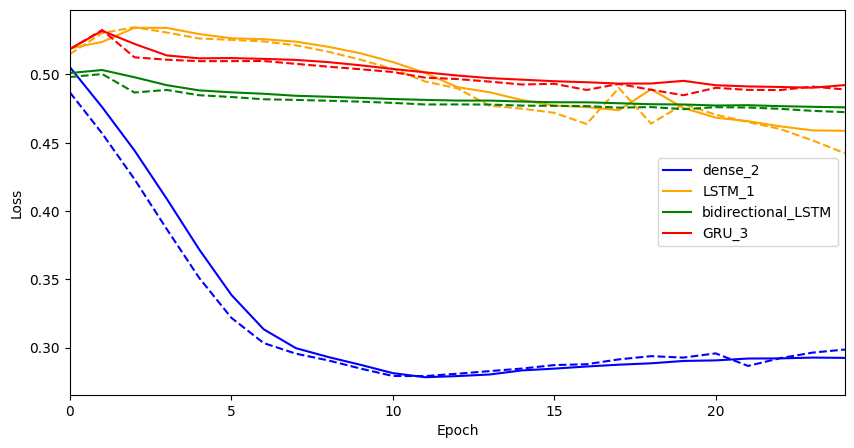

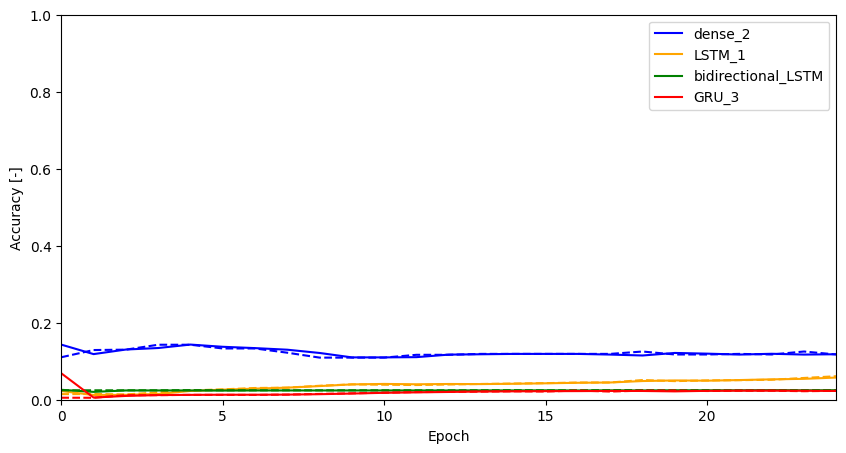

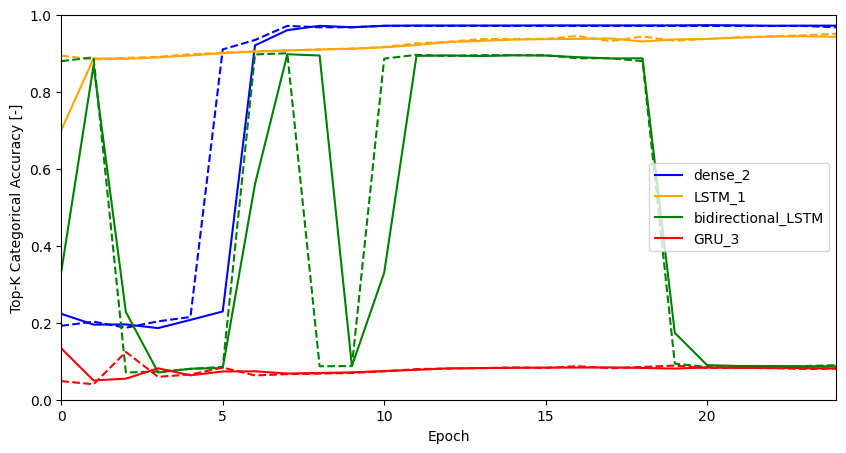

In [95]:
show_plots(results_1, model_names, colors, "25")

---
Perform the same for larger number of epochs: 50.

In [96]:
models_1_50 = get_all_models()

results_1_50 = train_models(models_1, X_train_1, y_train_1, X_test_1, y_test_1, epochs=50, batch_size=batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

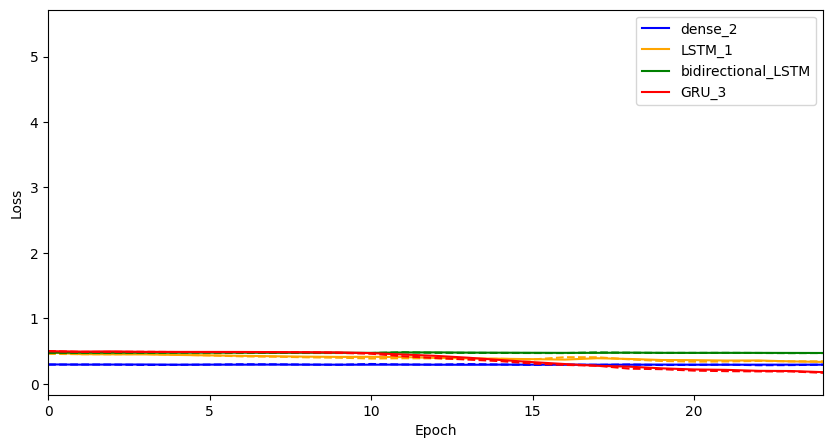

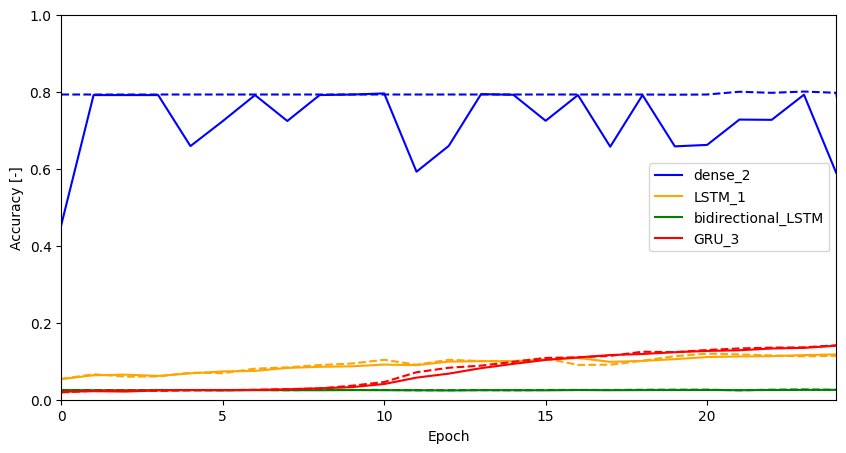

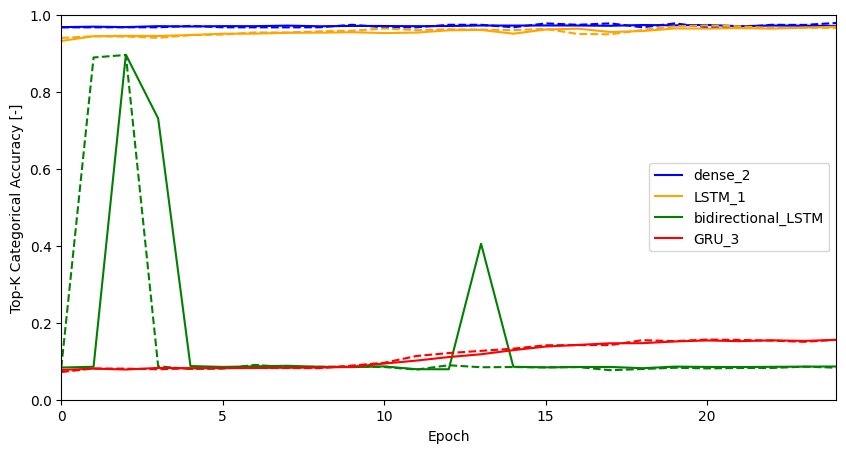

In [97]:
show_plots(results_1_50, model_names, colors, "50")

In [98]:
models_3 = get_all_models()

results_3 = train_models(models_3, X_train_3, y_train_3, X_test_3, y_test_3, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

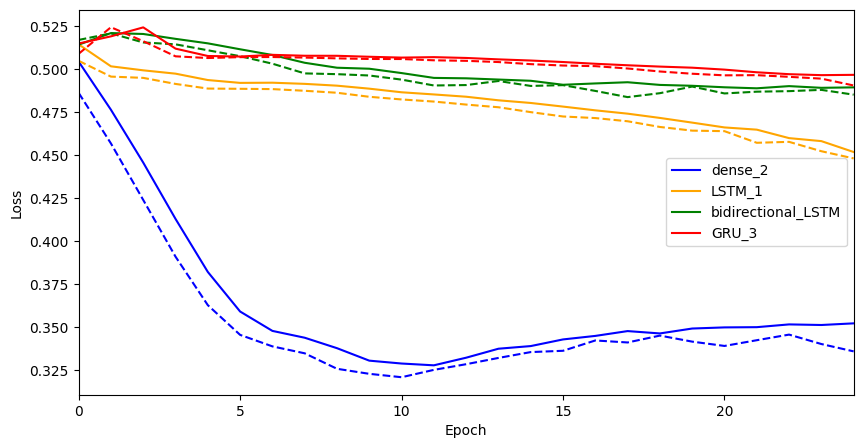

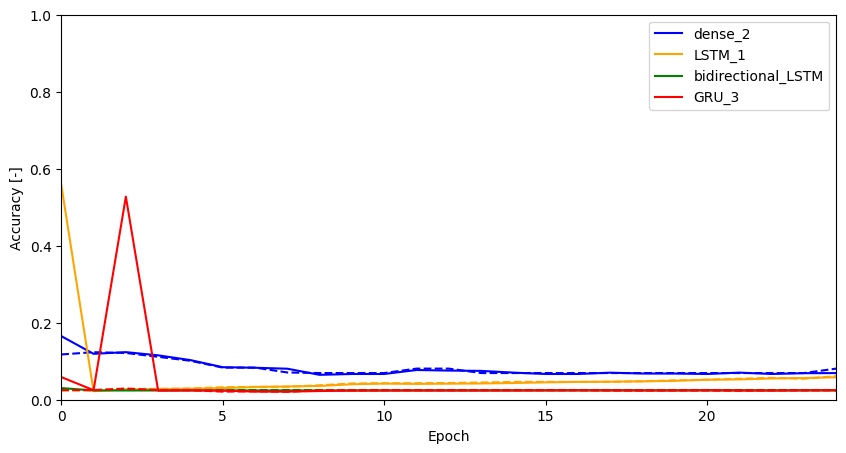

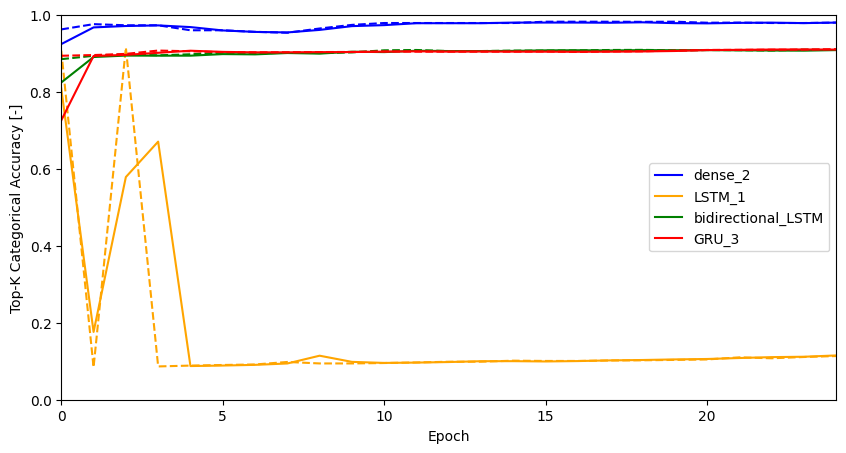

In [99]:
show_plots(results_3, model_names, colors, "25_3")

---
Create a list of all models and train them using *train_models* function, using datasets with five gaps.

In [100]:
models_5 = get_all_models()

results_5 = train_models(models_5, X_train_5, y_train_5, X_test_5, y_test_5, epochs, batch_size, verbose=0)

---
Display plots of loss function, accuracy and top-5 categorical accuracy throughout the training.

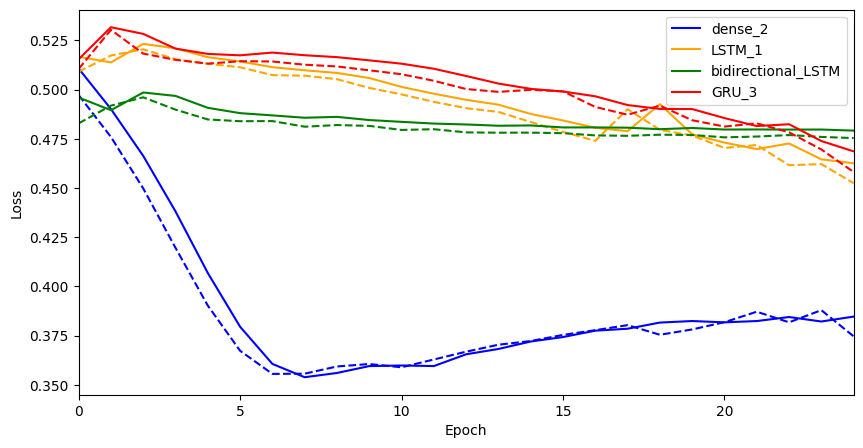

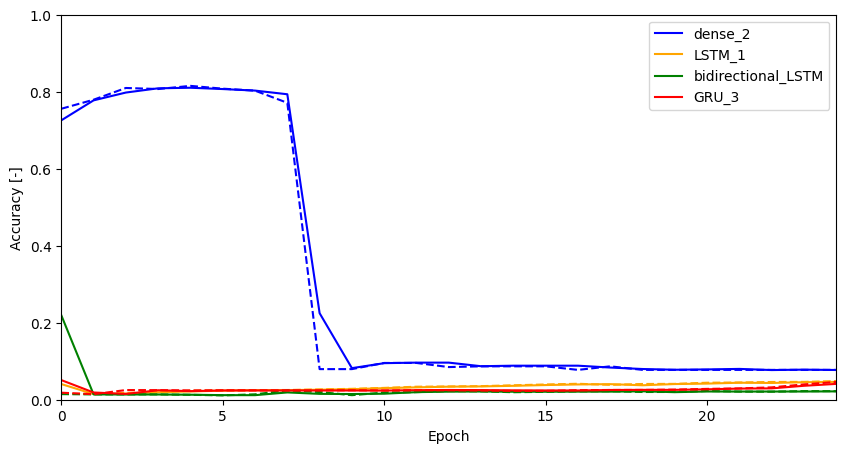

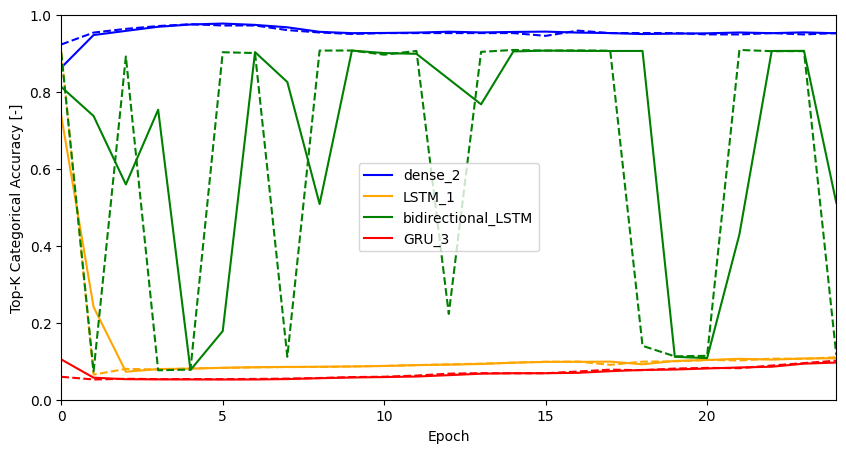

In [101]:
show_plots(results_5, model_names, colors, "25_5")